In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  7 17:45:19 2017

@author: matt
"""
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import scipy
import random
import copy
#import pyvcf


# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from itertools import izip as zip, count # izip for maximum efficiency

rowCount=0
with open('/home/matt/genotype_report_080817.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        if rowCount==0:
            alldata = []                                   
            colVals=row
            #find when assays start
            indexAssaystart1=row.index('C__25986767_70')
            #find when SNPs start
            indexSNPstart1=row.index('rs5030865')
            indexAssaystart2=row.index('C__26544178_30')
            indexSNPstart2=row.index('CYP2C19*10/680C>T')
            indexCNVstart=row.index('Hs04502391_cn')
        else:
            alldata.append(row)
        colCount=len(row)
        rowCount=rowCount+1
 

    #sort column values for easy comparison
labelSorted=sorted(colVals)        
diagCodes=np.zeros((rowCount,indexAssaystart1))
genoCodes=np.zeros((rowCount,len(colVals)-indexAssaystart1))
genoCodesData=np.zeros((rowCount,len(colVals)-indexAssaystart1))

# could fix and make more efficient to fill diagCodes
# diagCodes=[all(tuple) for tuple in zip(*alldata)]

#transpose list to easily access column data   
categoryData=map(list, zip(*alldata))

#get unique elements of each column
els=[]
for test in categoryData:
    els.append(list(set(test)))
    
alldata_copy=copy.deepcopy(alldata)

rowNum=0
for row in alldata:                    
    colNum=0
    for col in row[0:indexAssaystart1-1]:
        if col=='TRUE':
            diagCodes[rowNum,colNum]=int(col == 'TRUE')
#         if colNum==0:
#             diagCodes[rowNum,colNum]=col
        colNum=colNum+1
        
    colNum=indexAssaystart1
    for col in row[indexAssaystart1:]:
        if col=='none':
            genoCodes[rowNum,colNum-indexAssaystart1]=0
            alldata_copy[rowNum][colNum]=''
        else:
            genoCodes[rowNum,colNum-indexAssaystart1]=1
            elnum=1
            for el in els[colNum]:
                if col==el:
                    genoCodesData[rowNum,colNum-indexAssaystart1]=elnum
                    check=['UND','N/A','INV']
                    if col in check:
                        genoCodesData[rowNum,colNum-indexAssaystart1]=0
                        genoCodes[rowNum,colNum-indexAssaystart1]=0
                        alldata_copy[rowNum][colNum]=''
                elnum=elnum+1
        try:
            ind=els[colNum].index('none')
            els[colNum][ind]=['']
        except:
            pass
        
        colNum=colNum+1
    rowNum=rowNum+1
    
    

In [2]:
#looking at diagnosis codes

commonCodes=[]
commonCodeinds=np.where(sum(diagCodes)>50)[0]
commonCodeinds_sorted=sorted(range(len(commonCodeinds)), key=sum(diagCodes)[commonCodeinds].__getitem__)
for i in commonCodeinds_sorted:
    commonCodes.append(colVals[commonCodeinds[i]])
print commonCodes

['M54.17', 'E55.9', 'E78.0', 'F41.9', 'R53.83', 'M54.5', 'E78.2', 'F32.9', 'F14.10', 'Z79.891', 'F11.120', 'F10.10', 'E78.5', 'E03.9', 'F11.10', 'K21.9', 'F15.20', 'E11.9', 'F41.1', 'Z13.79', 'A59.00', 'F13.20', 'F11.20', '', 'B37.3', 'Z11.3', 'I10', 'N76.0', 'Z79.899', 'T50.905A']


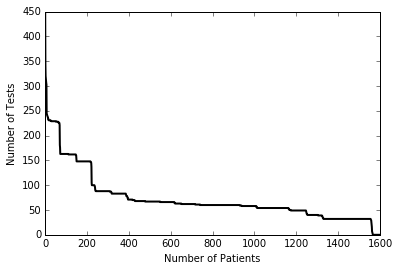

In [258]:
npt=[]
for i in range(0,1600):
    npt.append(len(np.where(sum(genoCodes)>i)[0]))
cax=plt.subplot(111)
plt.plot(range(0,1600),npt,color='black',lw=2)
xlo=plt.xlabel('Number of Patients')
ylo=plt.ylabel('Number of Tests')
# plt.setp(titleobj,color='w')
# plt.setp(xlo,color='w')
# plt.setp(ylo,color='w')
# axes_obj = plt.getp(cax,'axes')                        #get the axes' property handler
# plt.setp(plt.getp(axes_obj, 'yticklabels'), color='w') #set yticklabels color
# plt.setp(plt.getp(axes_obj, 'xticklabels'), color='w') #set xticklabels color 
plt.savefig('testsperpt.png', format='png')
plt.show()


In [257]:
len(genoCodes)

3567

In [3]:
drugCodes=[colVals.index('T50.905A'),colVals.index('Z79.899'),colVals.index('F11.20'),colVals.index('F13.20'),
           colVals.index('F15.20')]
chromAbnormalityCode=colVals.index('Z13.79')
healthCodes=[colVals.index('E11.9'),colVals.index('I10')]
STDCodes=[colVals.index('B37.3'),colVals.index('N76.0'),colVals.index('A59.00'),colVals.index('Z11.3')]
unkCodes=[colVals.index('')]

drugICDs=[colVals[i] for i in drugCodes]
chromICDs=colVals[chromAbnormalityCode]
STDICDs=[colVals[i] for i in STDCodes]
healthICDs=[colVals[i] for i in healthCodes]
unkICDs=[colVals[i] for i in unkCodes]
#in reverse order with >50 diagnoses, so last is most common
commonDiags=['Radiculopathy','Vitamin D deficiency','Hypercholesterolemia','Anxiety disorder','Fatigue','Low back pain',
             'Mixed hyperlipidemia','Depressive disorder episode','Cocaine abuse','Long term opioid use',
             'Opioid abuse with intoxication','Alcohol abuse','Hyperlipidemia NOS','Hypothyroidism','Opioid abuse',
             'Esophageal reflux','Stimulant dependence','Diabetes','Anxiety','Chromosomal anomaly','Trichomoniasis',
             'Sedative dependence','Opioid dependence','','Candidiasis','STD screening','Hypertension',
             'Vaginitis','Long-term drug therapy','Adverse effect of drugs or medication']
groupNames=['pain/opioid','std','psychiatric','alcohol','stimulant/cocaine','weight-related','back pain','other']

diagGroups=[6,7,5,2,7,6,5,2,4,0,0,3,5,5,0,7,4,5,2,7,1,0,0,7,1,1,5,1,0,0]
codeColumn=[colVals.index(i) for i in commonCodes]
diagDict={'Diagnosis':commonDiags,'Code':commonCodes,'Group': diagGroups,'GroupNames': groupNames,'CodeColumn':codeColumn}

# fig, ax = plt.subplots()
# plt.plot(range(1,len(commonCodeinds)+1),sum(diagCodes[1:])[commonCodeinds[commonCodeinds_sorted]])
# plt.xticks(range(5,len(commonCodeinds)+1,5))
    # for tick in ax.get_xticklabels():
    #     tick.set_rotation(45)
# # ax.set_xticklabels([commonDiags[i-1] for i in range(5,len(commonCodeinds)+1,5)])

# plt.title('number of patients per diagnosis')
# plt.show()
# plt.savefig("test.eps", format="eps")
# #categorize each patient by its group name


In [251]:
len(useTests)

105

In [263]:
## select group number and filter data
%matplotlib inline
import matplotlib.pyplot as plt 

# use all patients
groupPts=range(len(alldata)+1)
#select data for each desired patient
groupPtData=[genoCodesData[i] for i in(groupPts)]

#how many patients had each test
ptThreshold=0 #automate this somehow? 0=more sparse, 222=compact subset w/>100 tests/pt, 1500=very compact, 20 tests/pt
useTests=np.where(sum(genoCodes)>ptThreshold)[0]
#only use patients with any of these tests done
usePts=np.where([sum(i[useTests]) for i in groupPtData])[0]

#indices of patients to use, relative to original dataframe
usePtInds=[groupPts[i] for i in usePts]

#select tests and patients to use
categoryData=map(list, zip(*[alldata_copy[i] for i in usePtInds]))

#get unique elements of each column again after subselecting and removing
els=[]
testind=0
testResultLabels=[]
sparseData=[]
for test in [categoryData[indexAssaystart1+i] for i in useTests]:
    results=list(set(test))
    results.sort()
#     els.append(results)
    for label in results:
        if label=='':
            continue
# #         elif label in ['1','2','3','4','5','6','7','8','9','10']:
# #             #copy number variation, so use actual numbers
# #             testResultLabels.append(colVals[indexAssaystart1+useTests[testind]]+'['+label+']')
        else:
            testResultLabels.append(colVals[indexAssaystart1+useTests[testind]]+'['+label+']')
    testind=testind+1
    
#manual one hot encoding: whoops!
testResultData=np.zeros([len(test),len(testResultLabels)])
colInd=0
testind=0
for test in [categoryData[indexAssaystart1+i] for i in useTests]:
    results=list(set(test))
    #remove labels of ''
    results.sort()
    emptInd=results.index('')
    del results[emptInd]
    
    for label in results:
        ptInds=np.where([i==label for i in test])[0]
        for i in ptInds: testResultData[i,colInd]=1
        colInd=colInd+1
    testind=testind+1    
    
    
# groupPtDataUse=[]
# for pt in usePtInds:
#     row=alldata_copy[pt]
#     dataval=[]
#     for col in useTests:
#         dataval.append(list(els[col+1111]).index(row[col+1111]))
#     groupPtDataUse.append(dataval)
        
#separate by specific diagnosis    
# groupPtDiagUse=diagCodes[np.ix_(usePtInds,codeInds)]

# fig, ax = plt.subplots()
# plt.pcolor(groupPtDiagUse)
# ax.set_xticklabels(sum(groupPtDiagUse))
# ax.xaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')

# sum(groupPtDiagUse)
# plt.show()

# test=categoryData[indexAssaystart1+useTests[0]]
# plt.pcolor(testResultData)
# plt.show()

#sklearn one hot encoding
%matplotlib inline
import matplotlib.pyplot as plt 
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
testResultLabels=[]

for test in useTests:
    data = categoryData[indexAssaystart1+test]
    values = array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)  
    
    featInd=0
    uselabs=[]
    for feat in onehot_encoded.T:
        label=label_encoder.inverse_transform([argmax(onehot_encoded[np.where(feat==1)[0][0], :])])
        if label!='':
            testResultLabels.append(colVals[test+indexAssaystart1]+'['+label[0]+']')
            uselabs.append(featInd)
        featInd=featInd+1
    if test==useTests[0]:
        testResultData=onehot_encoded[0:,uselabs]
    else:
        testResultData=np.concatenate((np.asarray(testResultData),np.asarray(onehot_encoded[0:,uselabs])),axis=1)

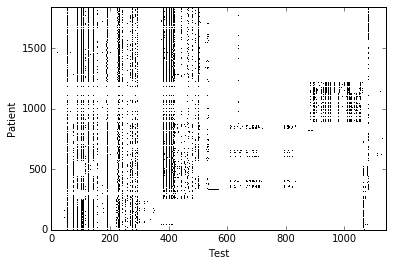

In [264]:
plt.pcolor(testResultData,cmap='Greys',vmin=0,vmax=1)
plt.xlim([0.0, len(testResultData[0])])
plt.ylim([0.0, len(testResultData)])
xlo=plt.xlabel('Test')
ylo=plt.ylabel('Patient')
plt.savefig("onehot.png", format="png")

not enough trials for Radiculopathy
not enough trials for Vitamin D deficiency
not enough trials for Hypercholesterolemia
not enough trials for Anxiety disorder


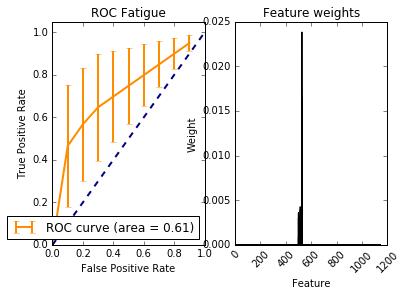

not enough trials for Mixed hyperlipidemia
not enough trials for Depressive disorder episode
not enough trials for Cocaine abuse
not enough trials for Opioid abuse with intoxication
not enough trials for Hyperlipidemia NOS
not enough trials for Hypothyroidism


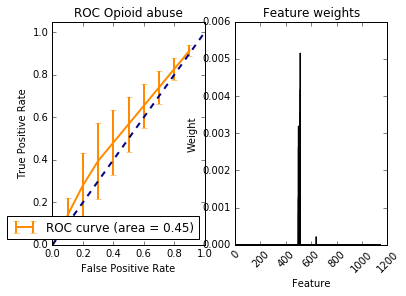

not enough trials for Esophageal reflux


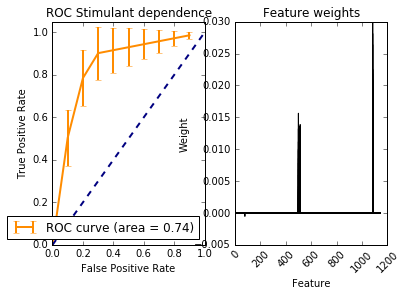

not enough trials for Diabetes


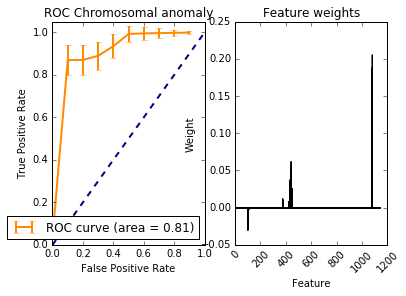

Chromosomal anomaly
r^2 on test data : 0.157482
not enough trials for Trichomoniasis


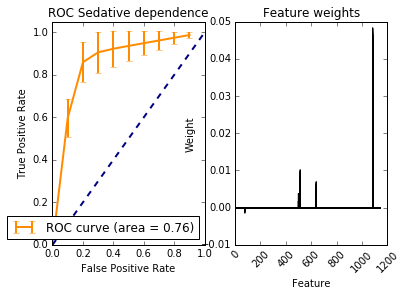

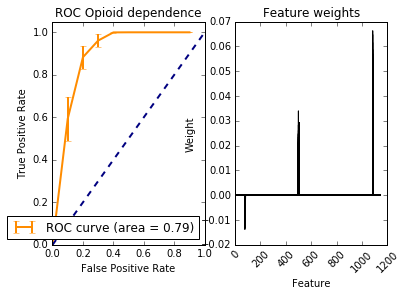

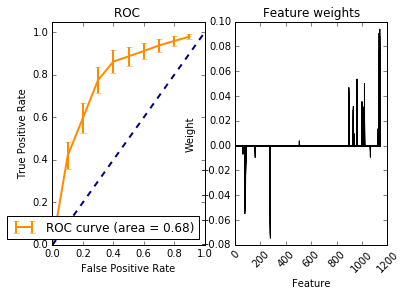

not enough trials for Candidiasis
not enough trials for STD screening


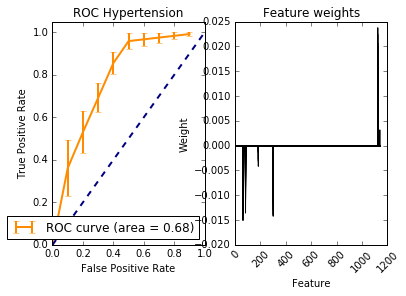

not enough trials for Vaginitis


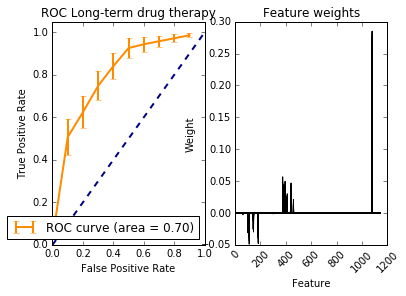

Long-term drug therapy
r^2 on test data : 0.227410


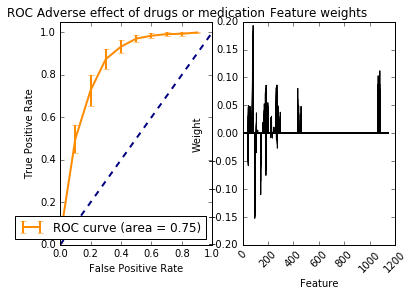

Adverse effect of drugs or medication
r^2 on test data : 0.138979


In [265]:
# lasso
# from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeavePOut, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, r2_score, accuracy_score

#classify: in diagnosis group or not
groupNum=5
groupCodeInds=np.where([i==groupNum for i in diagGroups])[0]
[diagDict['Diagnosis'][i] for i in groupCodeInds]
#in group or not
codeInds=[diagDict['CodeColumn'][i] for i in groupCodeInds]

#separate only patients in a specific group
# groupPts=np.where(sepPts)[0]

#first checking for each of the major diagnoses
diagCodes_use=diagCodes[usePtInds]
falsepos=[]
truepos=[]
roc_auc=[]
codeTest=[]
predComps=[]
predCompsWeights=[]
r2_score_lasso=[]
acc=[]
coefs=[]
for sortedInd in range(len(commonCodeinds_sorted)):
    coefs.append([])
    codeInd=commonCodeinds[commonCodeinds_sorted[sortedInd]]
    catPtDiagUse=np.zeros(len(diagCodes_use))
    catPtDiagUse[np.where(diagCodes_use.T[codeInd])[0]]=1
    
    X=testResultData
    Y=catPtDiagUse
    
#     ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25,random_state=0)
    trainfrac=8
    diagInds=np.where(catPtDiagUse==1)[0]
    if len(diagInds)<50:
        print('not enough trials for '+diagDict['Diagnosis'][sortedInd])
        continue
    numReps=100
    for rep in range(numReps):
        nSampsD=len(diagInds)
        nondiagInds=np.where(catPtDiagUse==0)[0]
        nSampsND=len(nondiagInds)
        randsampsD=np.random.choice(range(0,nSampsD),nSampsND)
        randsampsND=random.sample(range(0,nSampsND),nSampsND)
        #to balance, use nSampsD (number of samples with diagnosis) for selecting non-diagnosed pts too
        trainsamps=np.concatenate(([randsampsD[n] for n in range(0,nSampsND*trainfrac//10)],[randsampsND[n] for n in range(0,nSampsND*trainfrac//10)]),axis=0)
        testsamps=np.concatenate(([randsampsD[n] for n in range(nSampsND*trainfrac//10,nSampsND)],[randsampsND[n] for n in range(nSampsND*trainfrac//10,nSampsND)]),axis=0)

        X_train, X_test = X[trainsamps], X[testsamps]
        Y_train, Y_test = Y[trainsamps], Y[testsamps]
        reg = Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,normalize=False, positive=False, precompute=False, random_state=None,
                  selection='cyclic', tol=0.0001, warm_start=False)
        reg.fit(X_train,Y_train)
        Y_preds=reg.predict(X_test)

        fpr, tpr, _ = roc_curve(Y_test, Y_preds)
        tpr_interp=np.interp(np.asarray(range(0,10,1))/10.0,fpr,tpr)
        falsepos.append(np.asarray(range(0,10,1))/10.0)
        truepos.append(tpr_interp)
        roc_auc.append(auc(np.asarray(range(0,10,1))/10.0, tpr_interp))

        codeTest.append(codeInd)
        r2_score_lasso.append(r2_score(Y_test, Y_preds))
#         acc.append(metrics.accuracy_score(Y_test, Y_preds))
        coefs[-1].extend(reg.coef_)
    
    m=max(roc_auc[-numReps:])
    ind=(roc_auc[-numReps:].index(m))
    if roc_auc[-numReps:][ind]>0.7:
        fig=plt.figure()
        cax=plt.subplot(1,2,1)
        plt.errorbar(np.mean(falsepos[-numReps:],axis=0), np.mean(truepos[-numReps:],axis=0),np.std(truepos[-numReps:],axis=0), 
                     color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % np.mean(roc_auc[-numReps:]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        xlo=plt.xlabel('False Positive Rate')
        ylo=plt.ylabel('True Positive Rate')
        titleobj=plt.title('ROC '+diagDict['Diagnosis'][sortedInd])
        plt.legend(loc="lower right")
#         plt.setp(titleobj,color='w')
#         plt.setp(xlo,color='w')
#         plt.setp(ylo,color='w')
#         axes_obj = plt.getp(cax,'axes')                        #get the axes' property handler
#         plt.setp(plt.getp(axes_obj, 'yticklabels'), color='w') #set yticklabels color
#         plt.setp(plt.getp(axes_obj, 'xticklabels'), color='w') #set xticklabels color 
        coefs[-1]=np.reshape(np.asarray(coefs[-1]),(numReps,len(coefs[-1])/numReps))
        cax=plt.subplot(1,2,2)
#         plt.plot(np.mean(coefs[-1],axis=0))
        for i in coefs[-1]:
            plt.plot(i,color='black')
        xlo=plt.xlabel('Feature')
        ylo=plt.ylabel('Weight')
        titleobj=plt.title('Feature weights')
        for tick in cax.get_xticklabels():
            tick.set_rotation(45)

#         plt.setp(titleobj,color='w')
#         plt.setp(xlo,color='w')
#         plt.setp(ylo,color='w')
#         axes_obj = plt.getp(cax,'axes')                        #get the axes' property handler
#         plt.setp(plt.getp(axes_obj, 'yticklabels'), color='w') #set yticklabels color
#         plt.setp(plt.getp(axes_obj, 'xticklabels'), color='w') #set xticklabels color      
        fig.savefig(diagDict['Diagnosis'][sortedInd]+'ROC_'+str(ptThreshold)+'ptmin_oversampled.eps', format='eps')
        plt.show()

        reginds_sorted=sorted(range(len(np.mean(coefs[-1],axis=0))), key=np.abs(np.mean(coefs[-1],axis=0)).__getitem__,reverse=True)
        predCompsWeights.append([np.mean(coefs[-1],axis=0)[i] for i in reginds_sorted[0:4]])
        predComps.append([diagDict['Diagnosis'][sortedInd],[testResultLabels[i] for i in reginds_sorted[0:4]]])
        if r2_score_lasso[-1]>0.1:
            print diagDict['Diagnosis'][sortedInd]
#             print(reg)
            print("r^2 on test data : %f" % r2_score_lasso[-1])
        coefs[-1]=list(coefs[-1])


In [267]:
[[predComps[i],predCompsWeights[i]] for i in range(0,len(predCompsWeights))]

[[['Fatigue',
   ['hCV11975250[C/C]',
    'hCV8726802[G/G]',
    'C__27861810_10[C/C]',
    'C__60732328_20[T/T]']],
  [0.0031346439732221824,
   0.00071333943502696325,
   0.00055431564646420681,
   7.4708379185708647e-05]],
 [['Opioid abuse',
   ['C__27861810_10[C/C]',
    'C__60732328_20[T/T]',
    'C__27830964_10[T/T]',
    'C____904973_10[C/C]']],
  [0.00024329017138501237,
   9.1944959951947616e-05,
   3.2233016876071993e-05,
   2.1868083836961709e-06]],
 [['Stimulant dependence',
   ['CYP2D6[2]',
    'C__27861810_10[C/C]',
    'C__60732328_20[T/T]',
    'C__27830964_10[T/T]']],
  [0.009701377311499431,
   0.0032534639529658181,
   0.0011020054450094877,
   0.00090734992400277176]],
 [['Chromosomal anomaly',
   ['Hs___04083572_Cn[2]',
    'C__30634202_10[G/G]',
    'C___7455701_10[G/G]',
    'C__27488117_10[C/C]']],
  [0.15099615491910121,
   -0.021525265038563918,
   0.020427293537229777,
   0.010323741579537552]],
 [['Sedative dependence',
   ['CYP2D6[2]',
    'C__27861810_10[C

In [205]:
# SVM
# from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.metrics import roc_curve, auc, r2_score, accuracy_score
from scipy import sparse

#classify: in diagnosis group or not
groupNum=5
groupCodeInds=np.where([i==groupNum for i in diagGroups])[0]
[diagDict['Diagnosis'][i] for i in groupCodeInds]
#in group or not
codeInds=[diagDict['CodeColumn'][i] for i in groupCodeInds]

#separate only patients in a specific group
# groupPts=np.where(sepPts)[0]

#first checking for each of the major diagnoses
diagCodes_use=diagCodes[usePtInds]
falsepos=[]
truepos=[]
roc_auc=[]
codeTest=[]
predComps=[]
r2_score_svc=[]
svcscore=[]
# for sortedInd in range(len(commonCodeinds_sorted)):
    
#     codeInd=commonCodeinds[commonCodeinds_sorted[sortedInd]]
    #for one diagnosis class
#     catPtDiagUse=np.zeros(len(diagCodes_use))
#     catPtDiagUse[np.where(diagCodes_use.T[codeInd])[0]]=1
    
X=testResultData
Y=map(list,zip(*[diagCodes_use[0:,i] for i in commonCodeinds[commonCodeinds_sorted]]))

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.25,random_state=0)
trainfrac=8

#     nSampsD=len(diagInds)
#     randsampsD=random.sample(range(0,nSampsD),nSampsD)

#     nondiagInds=np.where(catPtDiagUse==0)[0]
#     nSampsND=len(nondiagInds)
#     randsampsND=random.sample(range(0,nSampsND),nSampsND)
#     for rep in range(5):
#         trainsamps=np.concatenate(([randsampsD[n] for n in range(0,nSampsD*trainfrac//10)],[randsampsND[n] for n in range(0,nSampsD*trainfrac//10)]),axis=0)
#         testsamps=np.concatenate(([randsampsD[n] for n in range(nSampsD*trainfrac//10,nSampsD)],[randsampsND[n] for n in range(nSampsD*trainfrac//10,nSampsD)]),axis=0)
for trainsamps, testsamps in ss.split(X,Y):
    X_train, X_test = X[trainsamps], X[testsamps]
    Y_train, Y_test = Y[trainsamps], Y[testsamps]
    
    svclf=svm.LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=0.0001, C=0.01, multi_class='ovr', fit_intercept=True, 
                        intercept_scaling=1, class_weight='balanced', verbose=0, random_state=None, max_iter=1000)
    svclf.fit(sparse.csr_matrix(X_train),sparse.csr_matrix(Y_train))
    Y_preds_svc=svclf.predict(sparse.csr_matrix(X_test))

    fpr, tpr, _ = roc_curve(Y_test[range(len(Y_preds_svc))], Y_preds_svc)
    falsepos.append(fpr)
    truepos.append(tpr)
    roc_auc.append(auc(fpr, tpr))
#         codeTest.append(codeInd)
    r2_score_svc.append(r2_score(Y_test[range(len(Y_preds_svc))], Y_preds_svc))
    acc.append(metrics.accuracy_score(Y_test[:len(Y_preds_svc)], Y_preds_svc))
    svcscore.append(svclf.score(X_train,Y_train))

m=max(roc_auc[-5:])
ind=(roc_auc[-5:].index(m))
if roc_auc[-5:][ind]>0.8:
    fig=plt.figure()
    cax=plt.subplot(1,2,1)

    plt.plot(falsepos[-5:][ind], truepos[-5:][ind], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[-5:][ind])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    xlo=plt.xlabel('False Positive Rate')
    ylo=plt.ylabel('True Positive Rate')
    titleobj=plt.title('ROC '+diagDict['Diagnosis'][sortedInd])
    plt.legend(loc="lower right")
    plt.setp(titleobj,color='w')
    plt.setp(xlo,color='w')
    plt.setp(ylo,color='w')
    axes_obj = plt.getp(cax,'axes')                        #get the axes' property handler
    plt.setp(plt.getp(axes_obj, 'yticklabels'), color='w') #set yticklabels color
    plt.setp(plt.getp(axes_obj, 'xticklabels'), color='w') #set xticklabels color 

    if r2_score_svc[-1]>0.1:
        print diagDict['Diagnosis'][sortedInd]
#             print(reg)
        print("r^2 on test data : %f" % r2_score_svc[-1])
        


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
something wonky with how I put data into the multilabel SVM. allude to, let it be

In [339]:
r2_score_lasso

[-0.003934126420686912,
 -0.003934126420686912,
 -0.003934126420686912,
 -0.003934126420686912,
 -0.003934126420686912,
 0.00077375643203470013,
 0.00077375643203470013,
 0.00077375643203470013,
 0.00077375643203470013,
 0.00077375643203470013,
 -0.0010317033466946679,
 -0.0010317033466946679,
 -0.0010317033466946679,
 -0.0010317033466946679,
 -0.0010317033466946679,
 -0.001738880288560507,
 -0.001738880288560507,
 -0.001738880288560507,
 -0.001738880288560507,
 -0.001738880288560507,
 0.03187286140091572,
 0.03187286140091572,
 0.03187286140091572,
 0.03187286140091572,
 0.03187286140091572,
 -0.00084600963338665736,
 -0.00084600963338665736,
 -0.00084600963338665736,
 -0.00084600963338665736,
 -0.00084600963338665736,
 -0.029174332840773864,
 -0.029174332840773864,
 -0.029174332840773864,
 -0.029174332840773864,
 -0.029174332840773864,
 -0.00011329072392163297,
 -0.00011329072392163297,
 -0.00011329072392163297,
 -0.00011329072392163297,
 -0.00011329072392163297,
 0.00581574381328198

In [302]:
acc.append(metrics.accuracy_score(Y_test[:len(Y_preds)], Y_preds))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [90]:
testResultLabels

['C__25986767_70[]',
 'C__25986767_70[A/A]',
 'C__25986767_70[A/G]',
 'C__25986767_70[C/C]',
 'C__25986767_70[G]',
 'C__25986767_70[G/G]',
 'C__25986767_70[NOAMP]',
 'C__27861809_10[]',
 'C__27861809_10[A/A]',
 'C__27861809_10[A/G]',
 'C__27861809_10[C/C]',
 'C__27861809_10[G]',
 'C__27861809_10[G/G]',
 'C__27861809_10[NOAMP]',
 'C__30634136_10[]',
 'C__30634136_10[A]',
 'C__30634136_10[A/A]',
 'C__30634136_10[A/G]',
 'C__30634136_10[C/C]',
 'C__30634136_10[NOAMP]',
 'C__27531918_10[]',
 'C__27531918_10[A/A]',
 'C__27531918_10[C/C]',
 'C__27531918_10[G]',
 'C__27531918_10[G/G]',
 'C__27531918_10[NOAMP]',
 'C__30634127_10[]',
 'C__30634127_10[A/A]',
 'C__30634127_10[A/T]',
 'C__30634127_10[C/C]',
 'C__30634127_10[NOAMP]',
 'C__30634127_10[T]',
 'C__30634127_10[T/T]',
 'C__30634130_30[]',
 'C__30634130_30[A/A]',
 'C__30634130_30[C/C]',
 'C__30634130_30[C/T]',
 'C__30634130_30[NOAMP]',
 'C__30634130_30[T]',
 'C__30634130_30[T/T]',
 'C__25745302_30[]',
 'C__25745302_30[A/A]',
 'C__25745302